In [9]:
import numpy as np

data = np.loadtxt("lcdm_z0.txt")

k = np.float32(data[:, 0])
P_k = np.float32(data[:, 1])



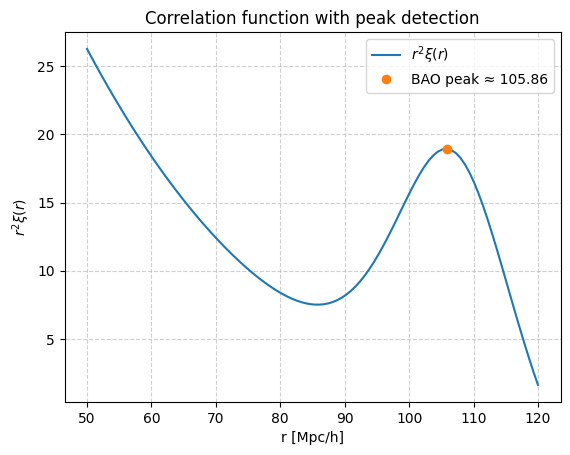

BAO peak at r ≈ 105.85858917236328 Mpc/h


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks


# cubic spline for P(k)
P_spline = CubicSpline(k.astype(np.float32), P_k.astype(np.float32))

# Romberg integration
def romberg(f, a, b, max_level=6, N0=128):
    R = np.zeros((max_level, max_level), dtype=np.float32)
    a = np.float32(a)
    b = np.float32(b)

    h = (b - a) / np.float32(N0)
    x = a + h * np.arange(1, N0, dtype=np.float32)
    R[0,0] = h * (0.5*f(a) + np.sum(f(x)) + 0.5*f(b))

    for i in range(1, max_level):
        N = N0 * 2**i
        h = (b - a) / np.float32(N)
        x_mid = a + h * np.arange(1, N, 2, dtype=np.float32)
        R[i,0] = 0.5*R[i-1,0] + h*np.sum(f(x_mid))
        for j in range(1, i+1):
            factor = np.float32(4**j - 1)
            R[i,j] = R[i,j-1] + (R[i,j-1] - R[i-1,j-1]) / factor

    return R[max_level-1, max_level-1]

# Correlation function xi(r) using cubic spline for P(k)
def xi_of_r(r):
    r = np.float32(r)
    def integrand(kk):
        kk = np.float32(kk)
        return kk**2 * P_spline(kk).astype(np.float32) * np.sin(kk*r)/(kk*r)
    return (np.float32(1.0)/(np.float32(2*np.pi**2))) * romberg(integrand, k[0], k[-1], max_level=12, N0=128)

r_vals = np.linspace(50, 120, 100, dtype=np.float32)
xi_vals = np.array([xi_of_r(r) for r in r_vals], dtype=np.float32)
y = r_vals**2 * xi_vals

# Find the peak
peaks, properties = find_peaks(y, prominence=0.0)  # adjust prominence if needed
peak_index = peaks[np.argmax(y[peaks])]
r_peak = r_vals[peak_index]
y_peak = y[peak_index]


plt.plot(r_vals, y, label=r"$r^2 \xi(r)$")
plt.plot(r_vals[peaks], y[peaks], "o", label=f"BAO peak, r ≈ {r_peak:.2f}")
plt.xlabel("r [Mpc/h]")
plt.ylabel(r"$r^2 \xi(r)$")
plt.title("Correlation function")
plt.legend()
plt.grid(True, ls="--", alpha=0.6)
plt.show()

print("BAO peak at r ≈", float(r_peak), "Mpc/h")

